In [1]:
import collections
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
!pip install spacy

In [2]:
import spacy

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, classification_report, roc_auc_score
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

In [3]:
!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [4]:
nlp = spacy.load('en_core_web_lg')

In [8]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
sample = pd.read_csv('./sample_submission.csv')

In [9]:
sample

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.5,0.5,0.5,0.5,0.5,0.5
1,0000247867823ef7,0.5,0.5,0.5,0.5,0.5,0.5
2,00013b17ad220c46,0.5,0.5,0.5,0.5,0.5,0.5
3,00017563c3f7919a,0.5,0.5,0.5,0.5,0.5,0.5
4,00017695ad8997eb,0.5,0.5,0.5,0.5,0.5,0.5
...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,0.5,0.5,0.5,0.5,0.5,0.5
153160,fffd7a9a6eb32c16,0.5,0.5,0.5,0.5,0.5,0.5
153161,fffda9e8d6fafa9e,0.5,0.5,0.5,0.5,0.5,0.5
153162,fffe8f1340a79fc2,0.5,0.5,0.5,0.5,0.5,0.5


In [10]:
target_columns = list(sample.columns.drop('id'))
target_columns

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [11]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [12]:
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [13]:
train[target_columns].sum()

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

In [14]:
train['non-toxic'] = 1-train[target_columns].max(axis=1)

train['toxicity_type_defined'] = train[['insult','obscene','identity_hate','threat']].max(axis=1)

train['toxic_undefined'] = 0
train.loc[(train['toxicity_type_defined']==0)&(train['toxic']==1),'toxic_undefined'] = 1

train['soft_toxic'] = 0
train.loc[(train['toxicity_type_defined']==1)&(train['toxic']==0),'soft_toxic'] = 1

analysis_columns = target_columns + ['non-toxic', 'toxic_undefined', 'soft_toxic']

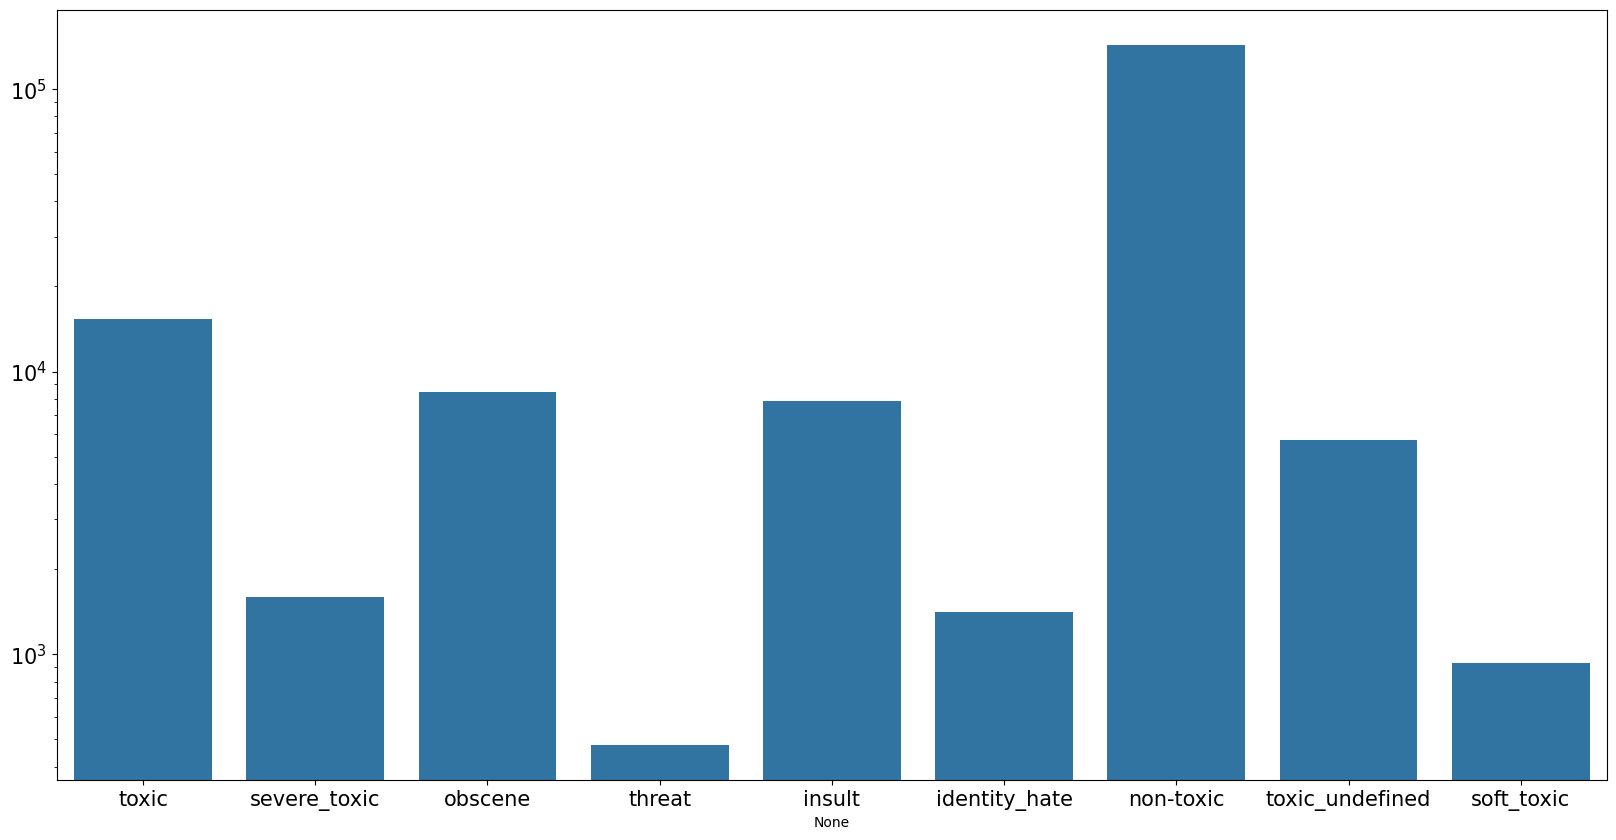

In [15]:
label_counts = train[analysis_columns].sum()
plt.figure(figsize=(20, 10))
ax = sns.barplot(x=label_counts.index, y=label_counts.values)
ax.set_yscale("log")
ax.tick_params(labelsize=15)

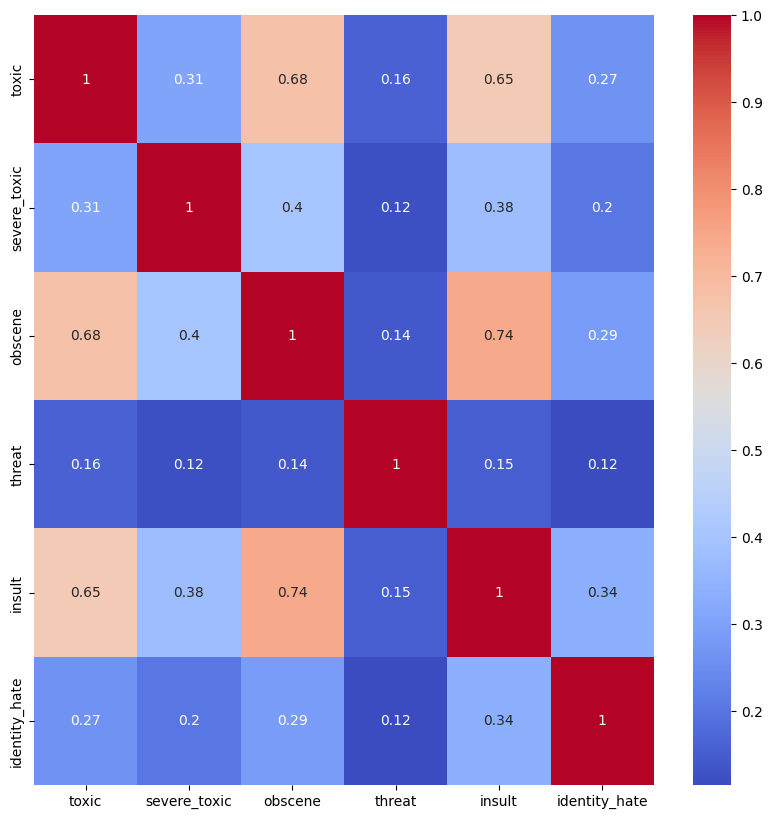

In [16]:
heatmap_data = train[target_columns]
plt.figure(figsize=(10, 10))
ax = sns.heatmap(heatmap_data.corr(), cmap='coolwarm', annot=True)
ax.tick_params(labelsize=10)

In [17]:
train.loc[train['severe_toxic']==1,'toxic'].sum()

1595

In [18]:
print(type(train))
print(train.columns)

<class 'pandas.core.frame.DataFrame'>
Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate', 'non-toxic', 'toxicity_type_defined',
       'toxic_undefined', 'soft_toxic'],
      dtype='object')


In [19]:
import pandas as pd

In [20]:
train_balanced = pd.concat([train[train['non-toxic'] == 1].sample(frac=0.11), train.loc[train['non-toxic'] == 0]])

In [21]:
train_balanced = train_balanced.sample(frac=1)


In [22]:
target_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'soft_toxic']

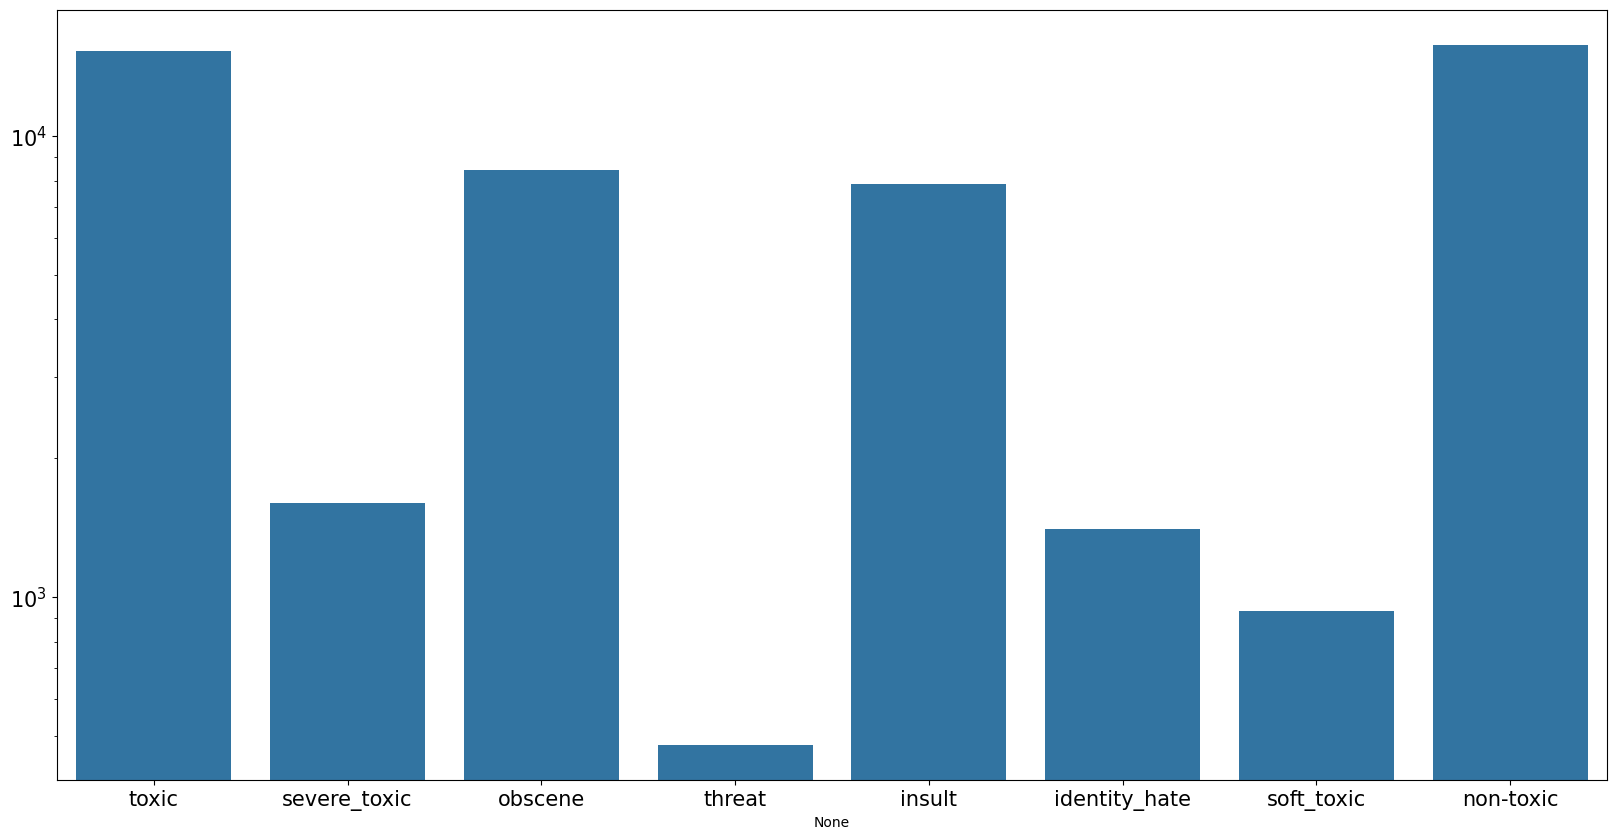

In [23]:
label_counts = train_balanced[target_columns + ['non-toxic']].sum()
plt.figure(figsize=(20, 10))
ax = sns.barplot(x=label_counts.index, y=label_counts.values)
ax.set_yscale("log")
ax.tick_params(labelsize=15)

In [25]:
all_tokens = []
lemmas = []
nonstop_tokens = []
total_number_of_tokens = []
number_of_sentences = []
number_of_puncts = []
glove_vector = []

for doc in nlp.pipe(train_balanced['comment_text'].astype('unicode').values, batch_size=50):
    if doc.has_annotation("DEP"):
        all_tokens.append([t.lower_ for t in doc])
        nonstop_tokens.append([t.lower_ for t in doc if t.is_alpha and not t.is_stop])
        lemmas.append([t.lemma_ for t in doc if t.is_alpha and not t.is_stop])
        total_number_of_tokens.append(doc.__len__())
        number_of_sentences.append(sum(1 for _ in doc.sents))
        number_of_puncts.append(sum(1 for t in doc if t.is_punct))
        glove_vector.append(doc.vector.tolist())
    else:
       all_tokens.append(None)
       nonstop_tokens.append(None)
       lemmas.append(None)
       total_number_of_tokens.append(None)
       number_of_sentences.append(None)
       number_of_puncts.append(None)
       glove_vector.append(None)

train_balanced['all_tokens'] = all_tokens
train_balanced['nonstop_tokens'] = nonstop_tokens
train_balanced['lemmas'] = lemmas
train_balanced['total_number_of_tokens'] = total_number_of_tokens
train_balanced['number_of_sentences'] = number_of_sentences
train_balanced['number_of_puncts'] = number_of_puncts
train_balanced['glove_vector'] = glove_vector

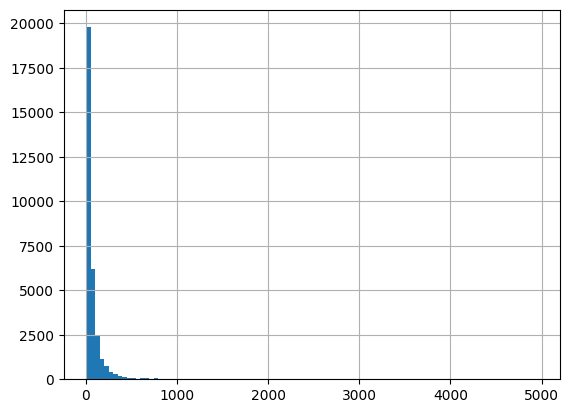

In [26]:
length = train_balanced['total_number_of_tokens']
length.hist(bins=100);

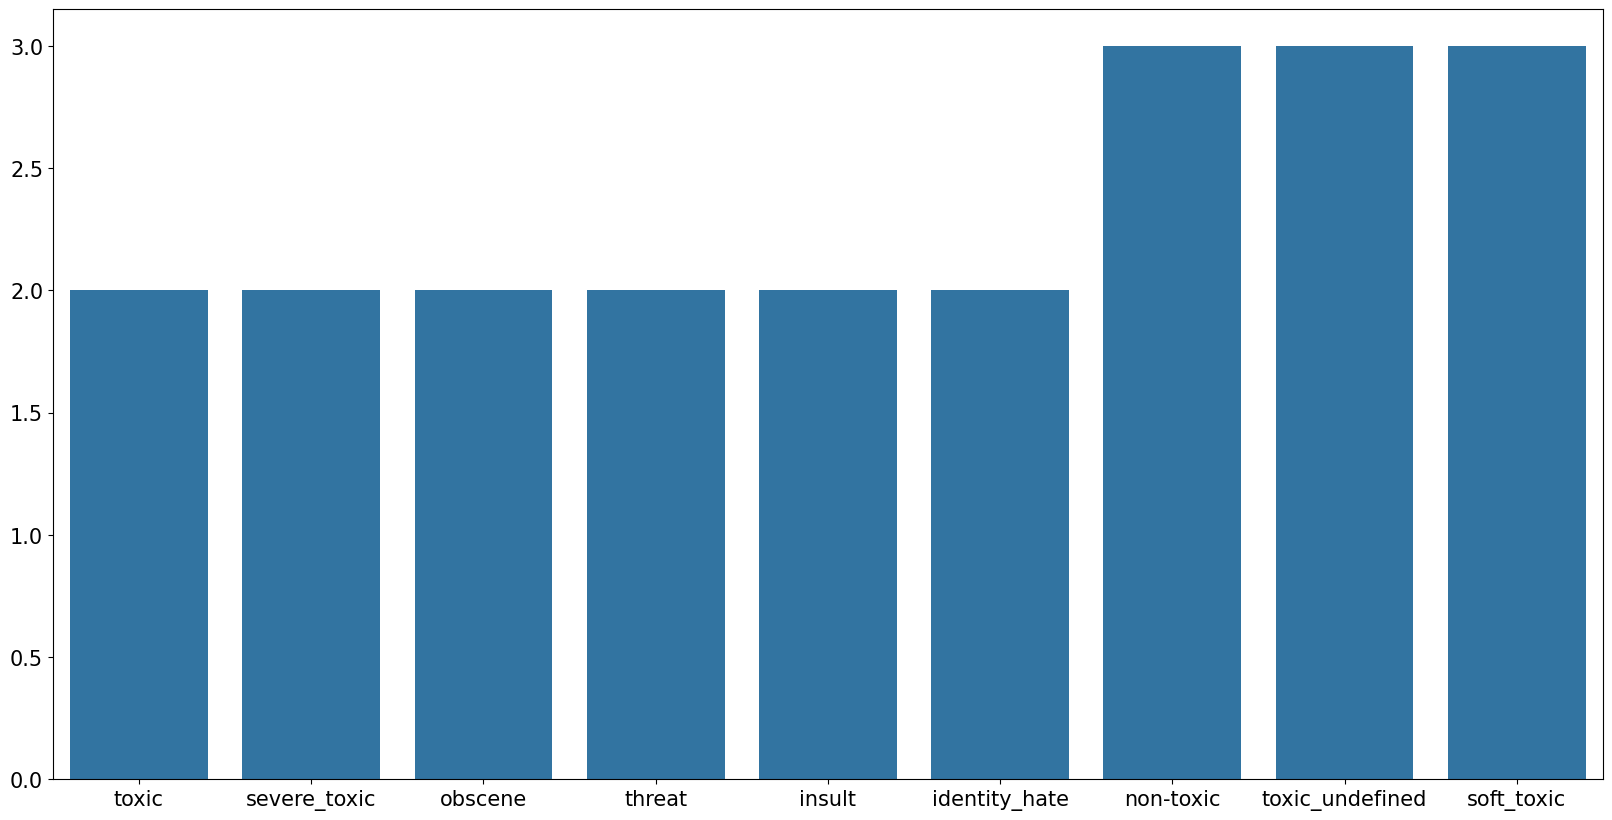

In [27]:
mc_length = []

for label in analysis_columns:
    mc_length.append(train_balanced.loc[train_balanced[label]==1,'number_of_sentences'].median())

plt.figure(figsize=(20, 10))
ax = sns.barplot(x=analysis_columns, y=mc_length)
ax.tick_params(labelsize=15)

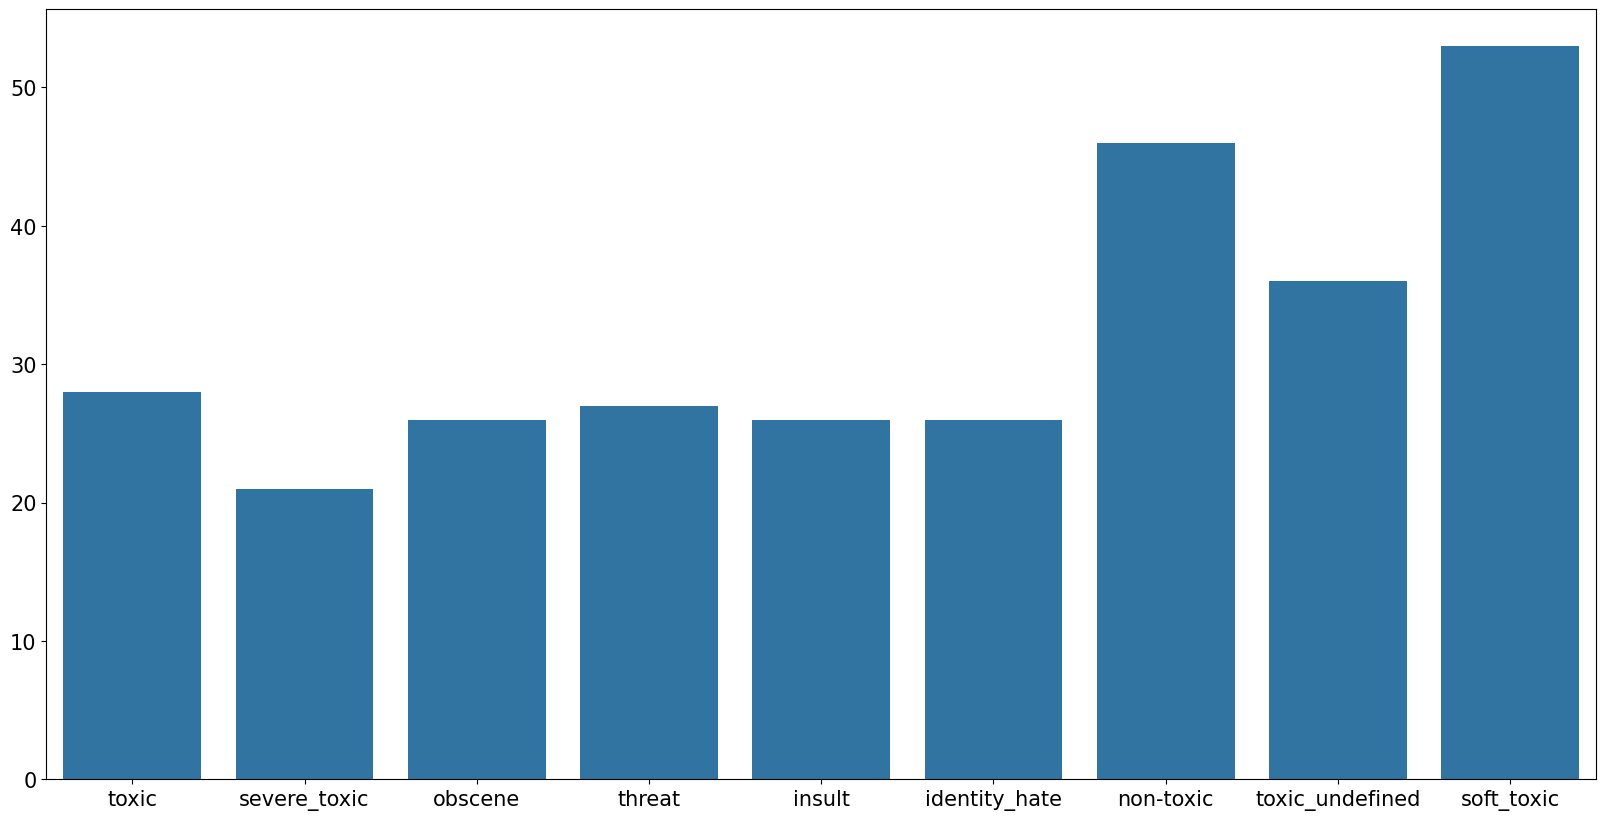

In [28]:
mc_length = []

for label in analysis_columns:
    mc_length.append(train_balanced.loc[train_balanced[label]==1,'total_number_of_tokens'].median())

plt.figure(figsize=(20, 10))
ax = sns.barplot(x=analysis_columns, y=mc_length)
ax.tick_params(labelsize=15)

In [29]:
log_max = np.log(train_balanced['total_number_of_tokens'].max())
train_balanced['log_tokens'] = train_balanced['total_number_of_tokens']**(1/log_max)
upper = train_balanced['log_tokens'].max()
train_balanced['log_tokens_normalised'] = (train_balanced['log_tokens'])/(upper)

<ipython-input-30-cb7a33675be7>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
<ipython-input-30-cb7a33675be7>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
<ipython-input-30-cb7a33675be7>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
<ipython-input-30-cb7a33675be7>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
<ipython-input-30-cb7a33675be7>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
<ipython-input-30-cb7a33675be7>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(),rotatio

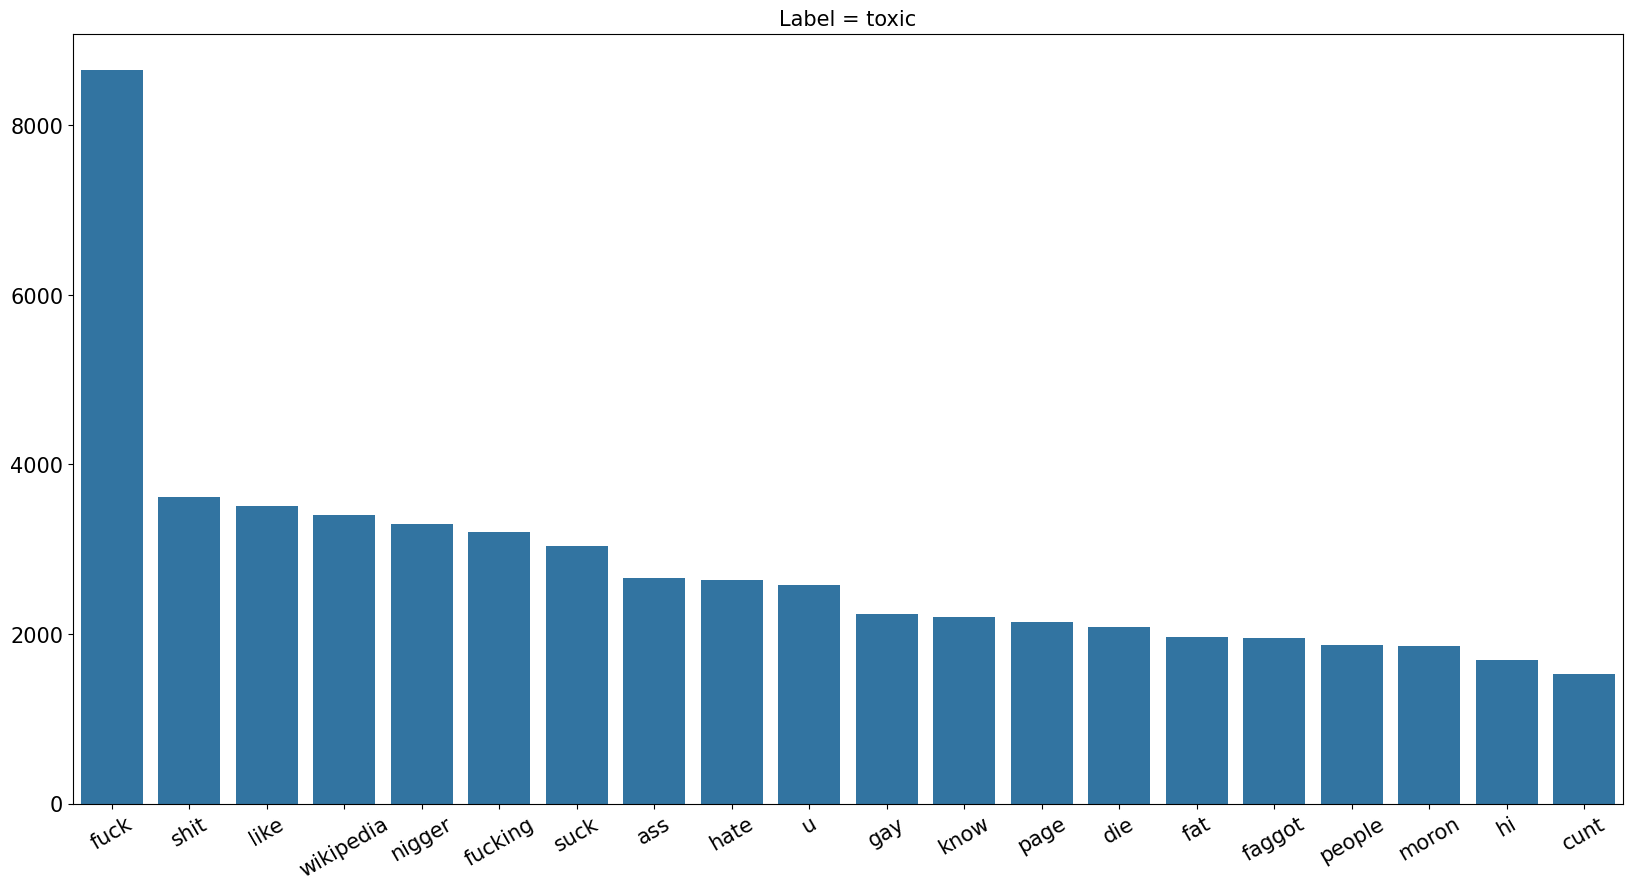

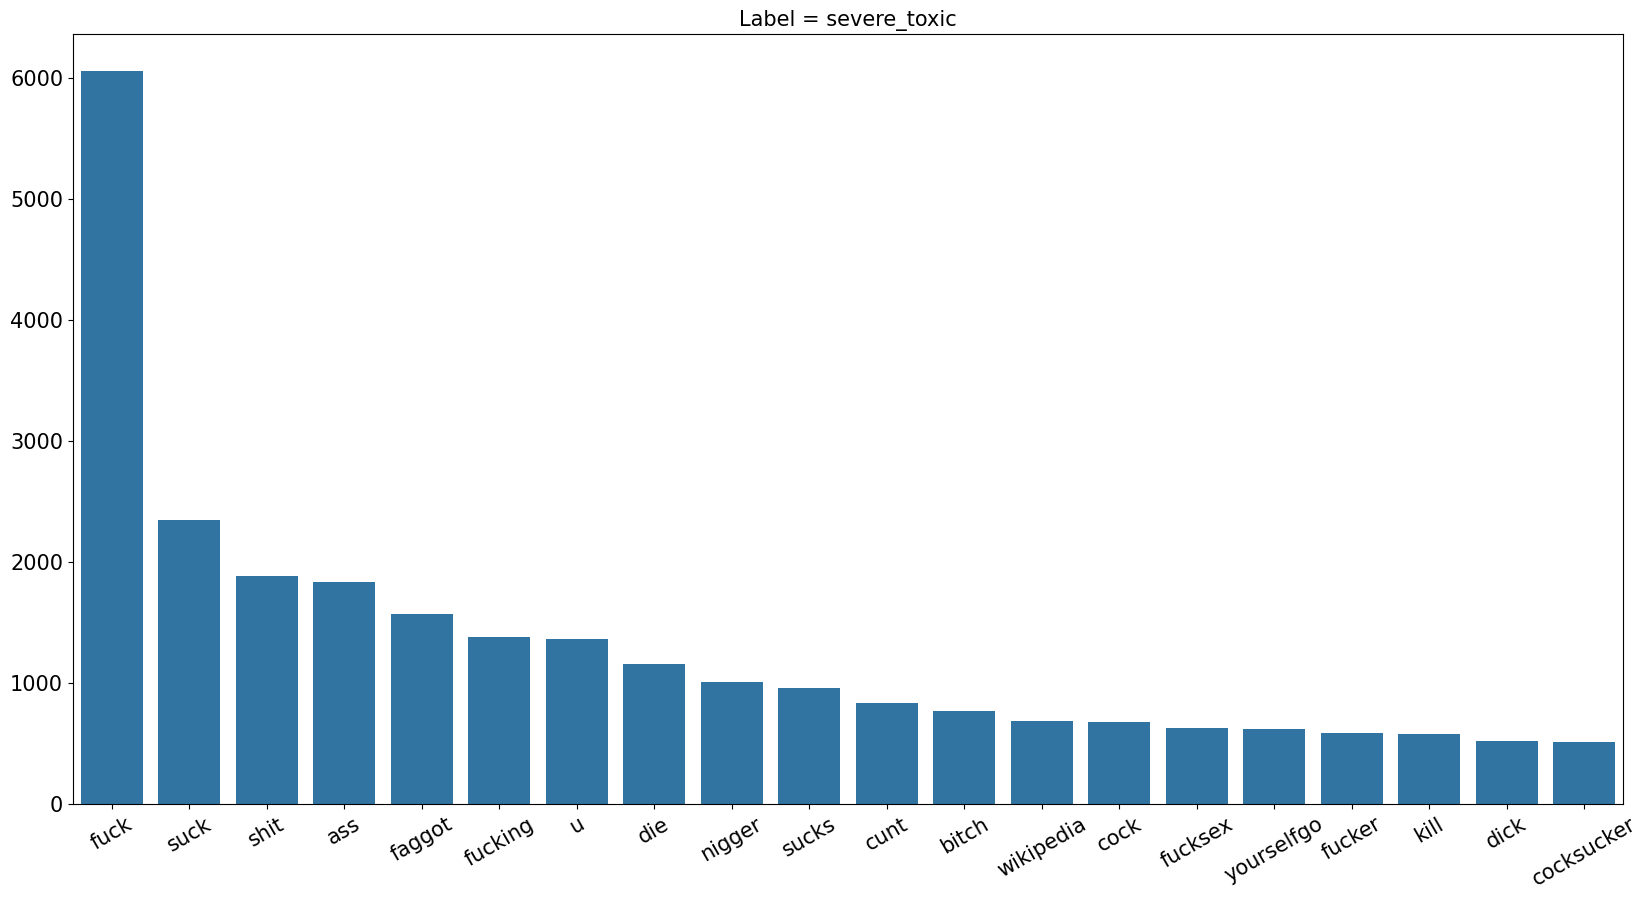

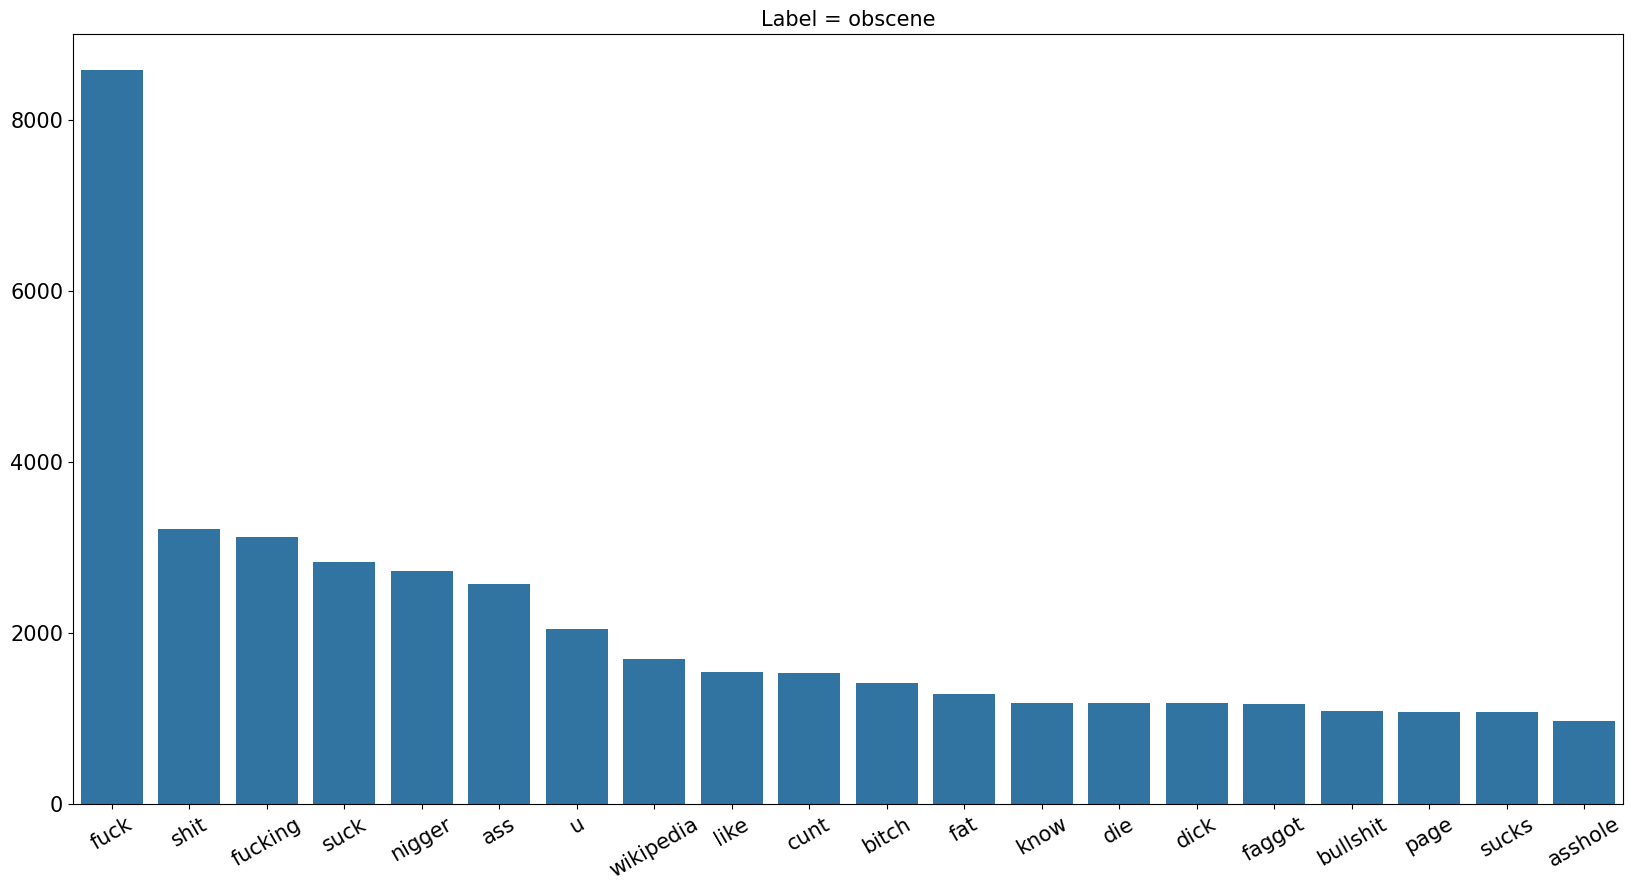

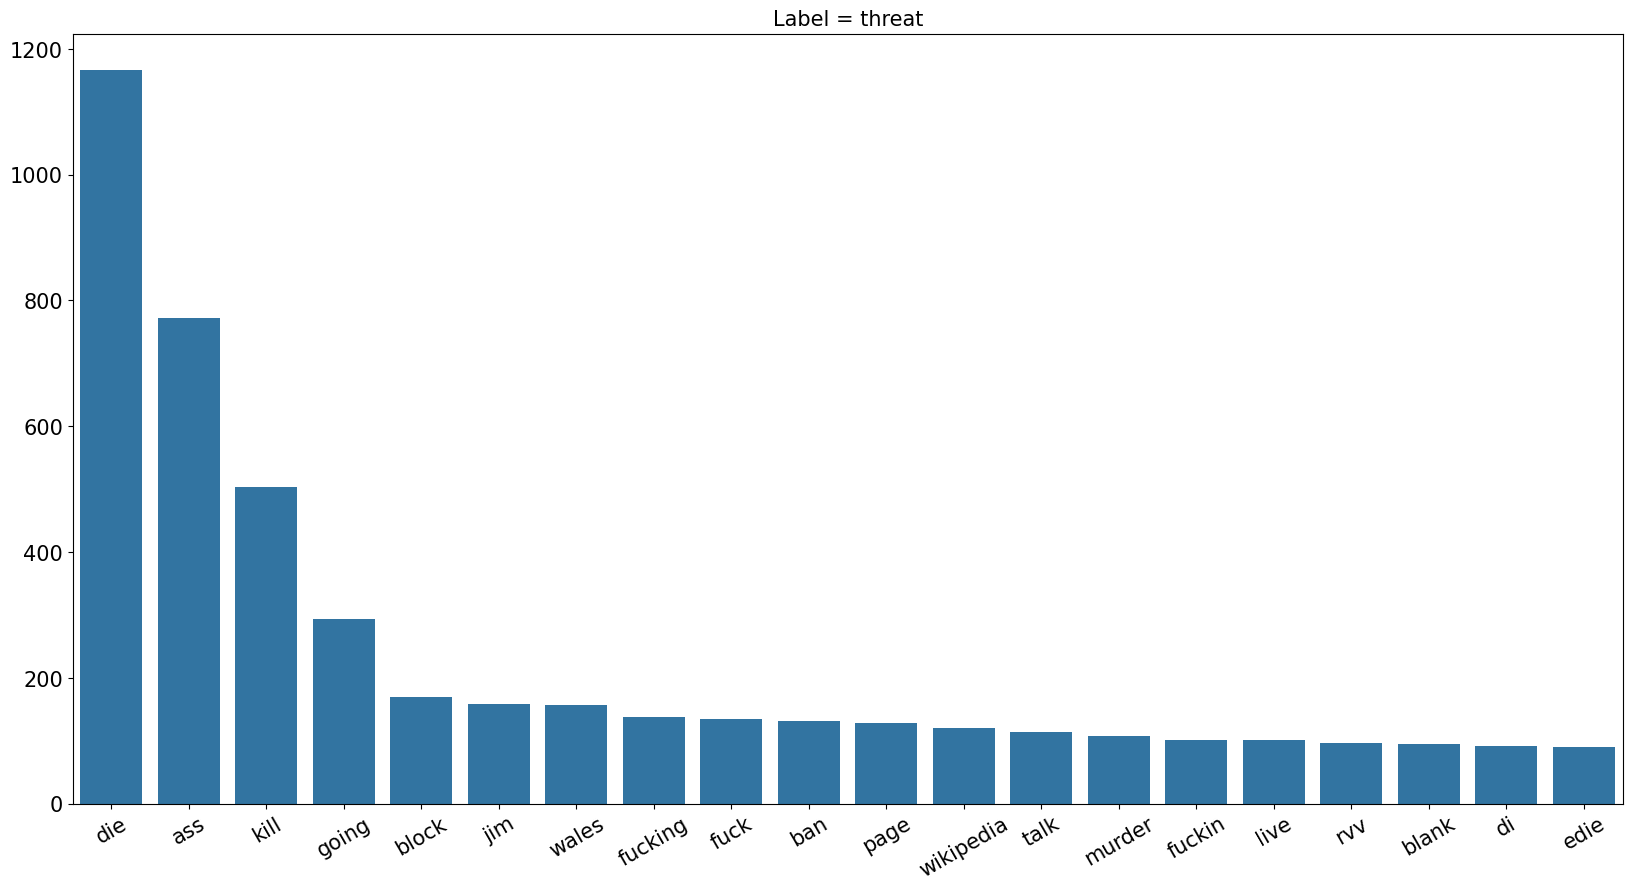

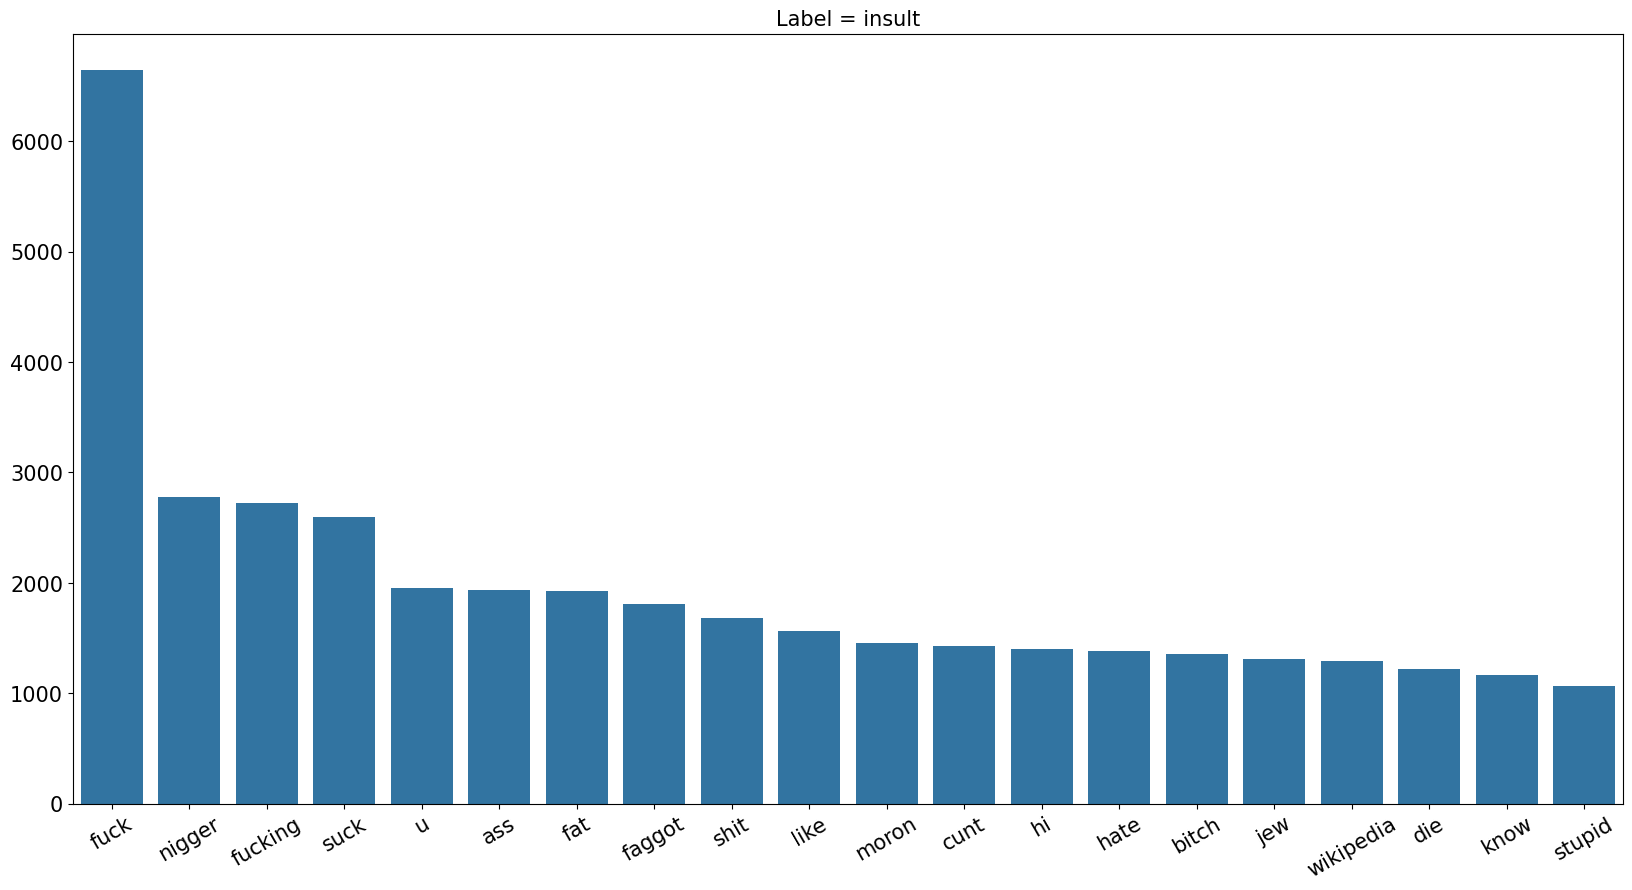

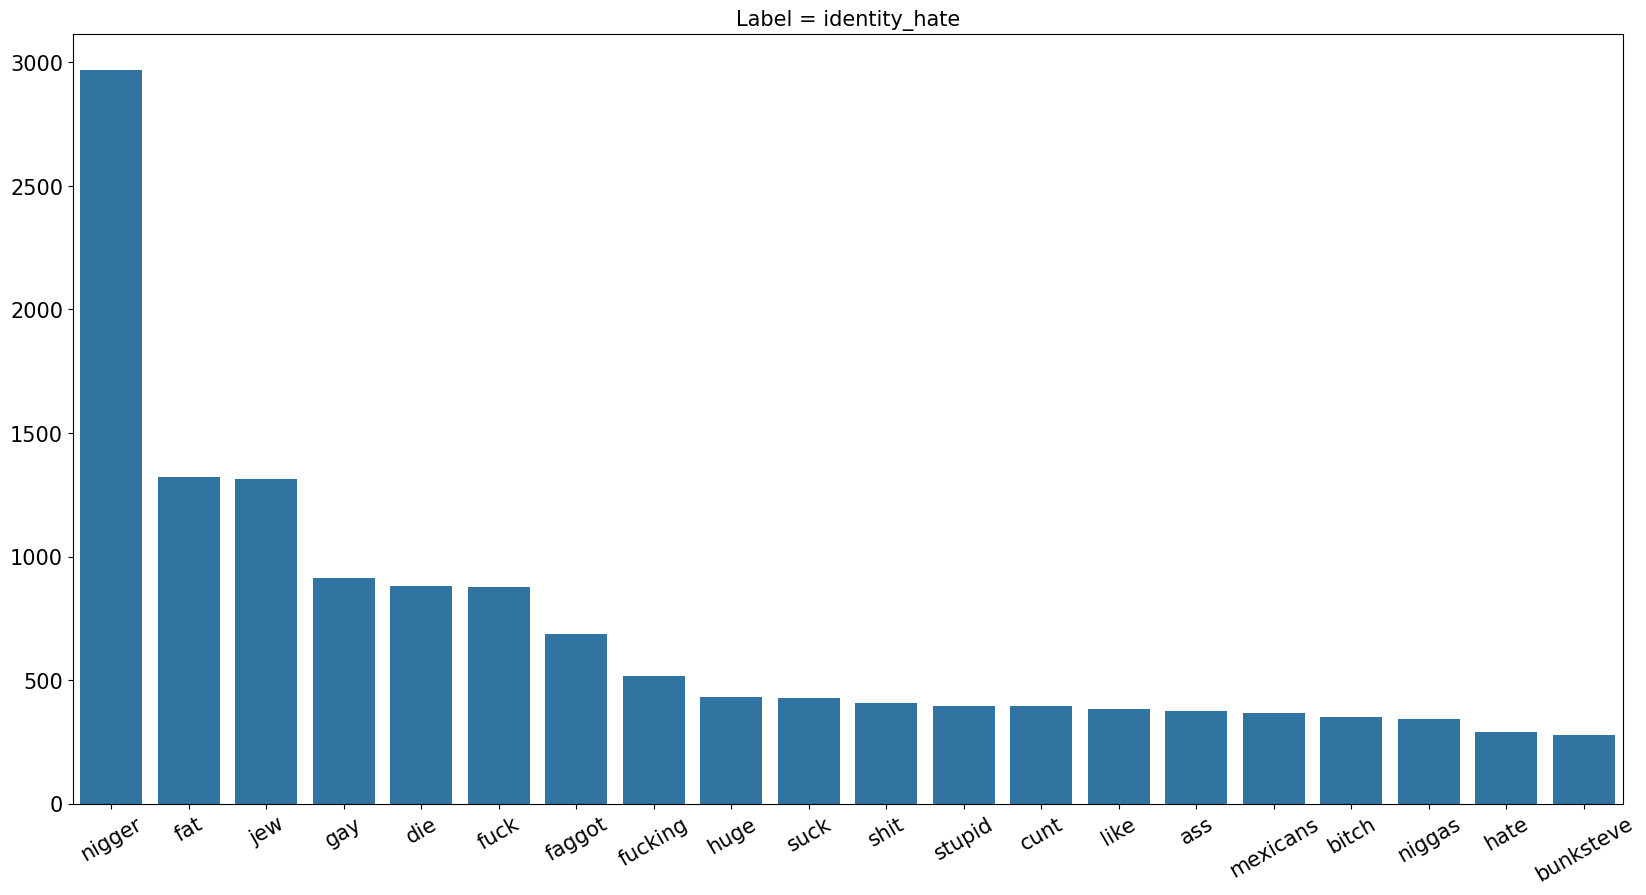

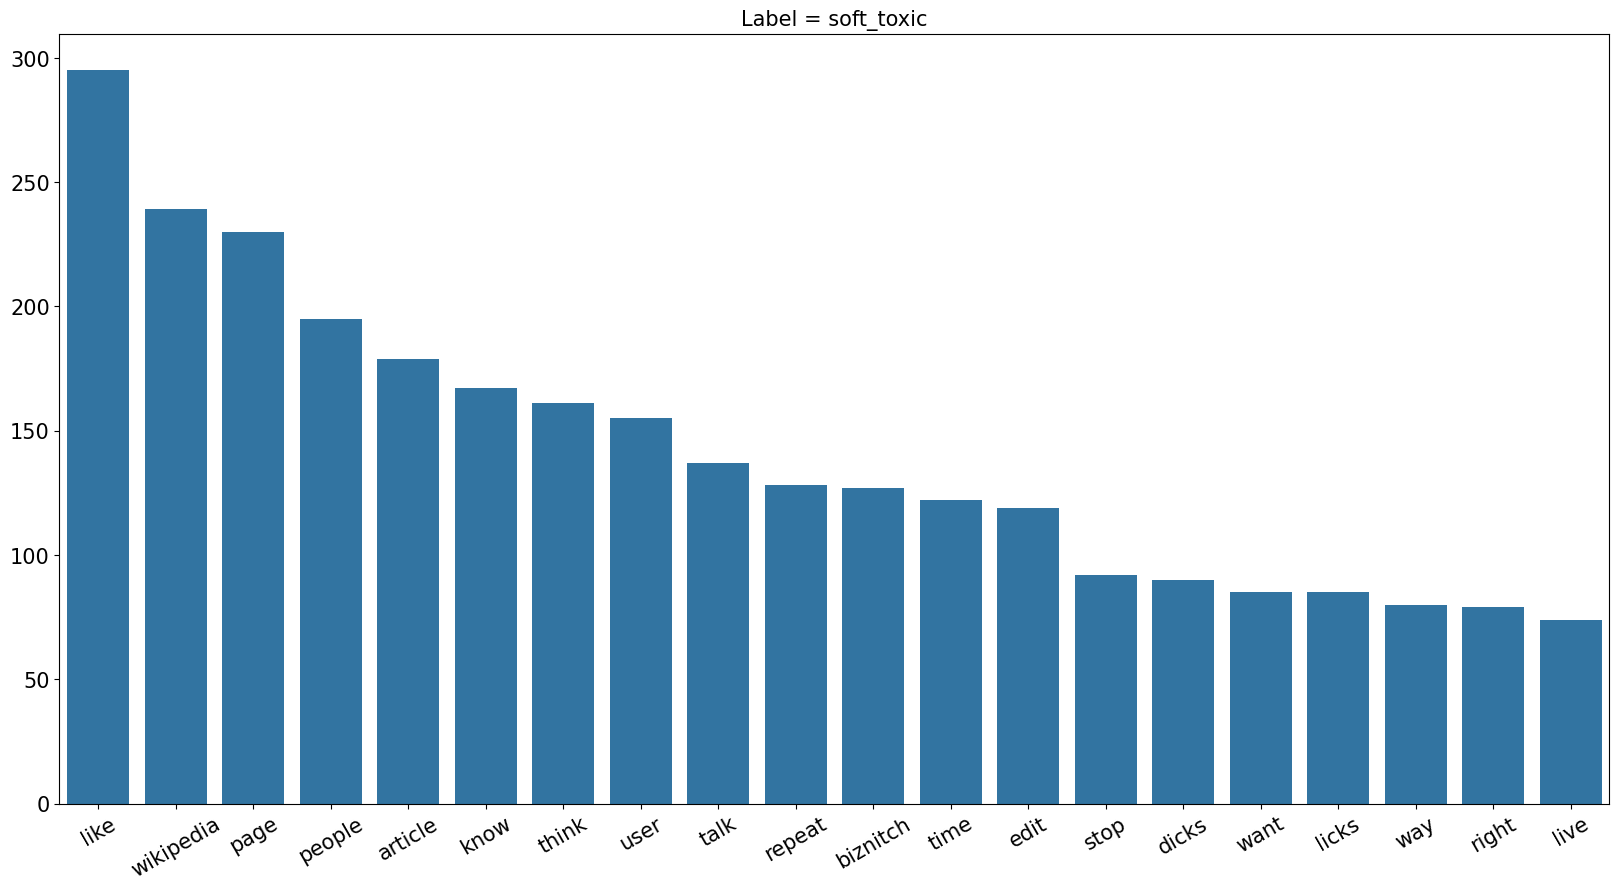

In [30]:
for label in target_columns:
    word_list = list(train_balanced.loc[train_balanced[label]==1, 'nonstop_tokens'].explode())
    most_common = collections.Counter(word_list).most_common(20)
    words = [w for w,_ in most_common]
    counts = [c for _,c in most_common]
    plt.figure(figsize=(20, 10))
    ax = sns.barplot(x=words, y=counts)
    ax.set_title(f'Label = {label}', fontsize=15)
    ax.tick_params(labelsize=15)
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)

In [31]:
val_border = int(len(train_balanced)*0.6)
validation_set = train_balanced[val_border:].copy()

In [32]:
compare_set = ['toxic', 'insult', 'obscene']

In [33]:
vectorizer = TfidfVectorizer(ngram_range=(1, 5), max_features=5000)
vectorizer.fit(train_balanced['comment_text'])
vectorizer

TfidfVectorizer(max_features=5000, ngram_range=(1, 5))

In [34]:
vectorizer.get_params()


{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': 5000,
 'min_df': 1,
 'ngram_range': (1, 5),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': None,
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'use_idf': True,
 'vocabulary': None}

In [35]:
x_train = vectorizer.transform(train_balanced['comment_text'])

In [36]:
lr_classifier = LogisticRegression(solver='liblinear')
average_roc = 0

for label in target_columns:
    lr_classifier.fit(x_train[:val_border], train_balanced[label][:val_border])
    predictions = lr_classifier.predict(x_train[val_border:])
    print(f'Label = {label}')
    print(classification_report(validation_set[label], predictions))
    print(f'AUC: {roc_auc_score(validation_set[label], predictions)}')
    average_roc += roc_auc_score(validation_set[label], predictions)

print(f'Average AUC: {average_roc/len(target_columns)}\n\n')

Label = toxic
              precision    recall  f1-score   support

           0       0.85      0.90      0.87      6622
           1       0.88      0.82      0.85      6176

    accuracy                           0.86     12798
   macro avg       0.86      0.86      0.86     12798
weighted avg       0.86      0.86      0.86     12798

AUC: 0.859898993267848
Label = severe_toxic
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     12160
           1       0.53      0.17      0.25       638

    accuracy                           0.95     12798
   macro avg       0.74      0.58      0.61     12798
weighted avg       0.94      0.95      0.94     12798

AUC: 0.5799495493730408
Label = obscene
              precision    recall  f1-score   support

           0       0.88      0.98      0.93      9409
           1       0.91      0.64      0.75      3389

    accuracy                           0.89     12798
   macro avg       0.90      0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [37]:
lr_classifier = LogisticRegression(solver='liblinear')
average_roc = 0

for label in target_columns:
    lr_classifier.fit(train_balanced['glove_vector'].to_list()[:val_border], train_balanced[label][:val_border])
    predictions = lr_classifier.predict(train_balanced['glove_vector'].to_list()[val_border:])
    print(f'Label = {label}')
    print(classification_report(validation_set[label], predictions))
    print(f'AUC: {roc_auc_score(validation_set[label], predictions)}')
    average_roc += roc_auc_score(validation_set[label], predictions)

print(f'Average AUC: {average_roc/len(target_columns)}\n\n')

Label = toxic
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      6622
           1       0.87      0.82      0.84      6176

    accuracy                           0.85     12798
   macro avg       0.85      0.85      0.85     12798
weighted avg       0.85      0.85      0.85     12798

AUC: 0.8517963897621839
Label = severe_toxic
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     12160
           1       0.48      0.18      0.26       638

    accuracy                           0.95     12798
   macro avg       0.72      0.58      0.62     12798
weighted avg       0.93      0.95      0.94     12798

AUC: 0.5828812025655833
Label = obscene
              precision    recall  f1-score   support

           0       0.87      0.94      0.90      9409
           1       0.78      0.60      0.68      3389

    accuracy                           0.85     12798
   macro avg       0.83      

In [38]:
sv_classifier = SVC()
average_roc = 0

for label in target_columns:
    sv_classifier.fit(x_train[:val_border], train_balanced[label][:val_border])
    predictions = sv_classifier.predict(x_train[val_border:])
    print(f'Label = {label}')
    print(classification_report(validation_set[label], predictions))
    print(f'AUC: {roc_auc_score(validation_set[label], predictions)}')
    average_roc += roc_auc_score(validation_set[label], predictions)

print(f'Average AUC: {average_roc/len(target_columns)}\n\n')

Label = toxic
              precision    recall  f1-score   support

           0       0.85      0.90      0.87      6622
           1       0.88      0.83      0.85      6176

    accuracy                           0.86     12798
   macro avg       0.86      0.86      0.86     12798
weighted avg       0.86      0.86      0.86     12798

AUC: 0.8607677266702451
Label = severe_toxic
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     12160
           1       0.60      0.08      0.15       638

    accuracy                           0.95     12798
   macro avg       0.78      0.54      0.56     12798
weighted avg       0.94      0.95      0.93     12798

AUC: 0.5408394860584063
Label = obscene
              precision    recall  f1-score   support

           0       0.89      0.98      0.93      9409
           1       0.91      0.66      0.76      3389

    accuracy                           0.89     12798
   macro avg       0.90      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [39]:
sv_classifier = SVC()
average_roc = 0

for label in target_columns:
    sv_classifier.fit(train_balanced['glove_vector'].to_list()[:val_border], train_balanced[label][:val_border])
    predictions = sv_classifier.predict(train_balanced['glove_vector'].to_list()[val_border:])
    print(f'Label = {label}')
    print(classification_report(validation_set[label], predictions))
    print(f'AUC: {roc_auc_score(validation_set[label], predictions)}')
    average_roc += roc_auc_score(validation_set[label], predictions)

print(f'Average AUC: {average_roc/len(target_columns)}\n\n')

Label = toxic
              precision    recall  f1-score   support

           0       0.85      0.88      0.87      6622
           1       0.87      0.83      0.85      6176

    accuracy                           0.86     12798
   macro avg       0.86      0.86      0.86     12798
weighted avg       0.86      0.86      0.86     12798

AUC: 0.8580691980179117
Label = severe_toxic
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     12160
           1       1.00      0.00      0.00       638

    accuracy                           0.95     12798
   macro avg       0.98      0.50      0.49     12798
weighted avg       0.95      0.95      0.93     12798

AUC: 0.5007836990595611
Label = obscene
              precision    recall  f1-score   support

           0       0.86      0.95      0.91      9409
           1       0.82      0.58      0.68      3389

    accuracy                           0.86     12798
   macro avg       0.84      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Label = insult
              precision    recall  f1-score   support

           0       0.85      0.95      0.90      9626
           1       0.76      0.50      0.61      3172

    accuracy                           0.84     12798
   macro avg       0.81      0.73      0.75     12798
weighted avg       0.83      0.84      0.83     12798

AUC: 0.7257697993218766
Label = identity_hate
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     12233
           1       0.43      0.01      0.01       565

    accuracy                           0.96     12798
   macro avg       0.69      0.50      0.49     12798
weighted avg       0.93      0.96      0.93     12798

AUC: 0.5024913750633894
Label = soft_toxic
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     12439
           1       0.00      0.00      0.00       359

    accuracy                           0.97     12798
   macro avg       0.49 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [40]:
mlp_classifier = MLPClassifier(max_iter=500)
average_roc = 0

for label in target_columns:
    mlp_classifier.fit(x_train[:val_border], train_balanced[label][:val_border])
    predictions = mlp_classifier.predict(x_train[val_border:])
    print(f'Label = {label}')
    print(classification_report(validation_set[label], predictions))
    print(f'AUC: {roc_auc_score(validation_set[label], predictions)}')
    average_roc += roc_auc_score(validation_set[label], predictions)

print(f'Average AUC: {average_roc/len(target_columns)}\n\n')

Label = toxic
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      6622
           1       0.83      0.83      0.83      6176

    accuracy                           0.83     12798
   macro avg       0.83      0.83      0.83     12798
weighted avg       0.83      0.83      0.83     12798

AUC: 0.8332315503510828
Label = severe_toxic
              precision    recall  f1-score   support

           0       0.96      0.97      0.97     12160
           1       0.35      0.29      0.32       638

    accuracy                           0.94     12798
   macro avg       0.66      0.63      0.64     12798
weighted avg       0.93      0.94      0.94     12798

AUC: 0.6301792453803002
Label = obscene
              precision    recall  f1-score   support

           0       0.91      0.92      0.91      9409
           1       0.76      0.73      0.75      3389

    accuracy                           0.87     12798
   macro avg       0.84      

In [41]:
mlp_classifier = MLPClassifier(max_iter=500)
average_roc = 0

for label in target_columns:
    mlp_classifier.fit(train_balanced['glove_vector'].to_list()[:val_border], train_balanced[label][:val_border])
    predictions = mlp_classifier.predict(train_balanced['glove_vector'].to_list()[val_border:])
    print(f'Label = {label}')
    print(classification_report(validation_set[label], predictions))
    print(f'AUC: {roc_auc_score(validation_set[label], predictions)}')
    average_roc += roc_auc_score(validation_set[label], predictions)

print(f'Average AUC: {average_roc/len(target_columns)}\n\n')

Label = toxic
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      6622
           1       0.83      0.85      0.84      6176

    accuracy                           0.85     12798
   macro avg       0.85      0.85      0.85     12798
weighted avg       0.85      0.85      0.85     12798

AUC: 0.8470037463440282
Label = severe_toxic
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     12160
           1       0.39      0.21      0.27       638

    accuracy                           0.94     12798
   macro avg       0.67      0.60      0.62     12798
weighted avg       0.93      0.94      0.94     12798

AUC: 0.5955971065005774
Label = obscene
              precision    recall  f1-score   support

           0       0.89      0.91      0.90      9409
           1       0.72      0.68      0.70      3389

    accuracy                           0.85     12798
   macro avg       0.81      

In [42]:
mlp_classifier = MLPClassifier(max_iter=1000)


mlp_classifier.fit(train_balanced['glove_vector'].to_list()[:val_border], train_balanced[target_columns][:val_border])
predictions = mlp_classifier.predict(train_balanced['glove_vector'].to_list()[val_border:])
probabilities = mlp_classifier.predict_proba(train_balanced['glove_vector'].to_list()[val_border:])

average_roc = 0
i = 0
for label in target_columns:
    print(f'Label = {label}')
    prediction = [p[i] for p in predictions]
    probability = [p[i] for p in probabilities]
    print(classification_report(validation_set[label], prediction))
    print(f'AUC: {roc_auc_score(validation_set[label], prediction)}\n\n')
    average_roc += roc_auc_score(validation_set[label], prediction)
    i += 1

print(f'Average AUC: {average_roc/len(target_columns)}\n\n')

Label = toxic
              precision    recall  f1-score   support

           0       0.85      0.84      0.85      6622
           1       0.83      0.84      0.84      6176

    accuracy                           0.84     12798
   macro avg       0.84      0.84      0.84     12798
weighted avg       0.84      0.84      0.84     12798

AUC: 0.8417787779156618


Label = severe_toxic
              precision    recall  f1-score   support

           0       0.97      0.96      0.96     12160
           1       0.34      0.35      0.34       638

    accuracy                           0.93     12798
   macro avg       0.65      0.66      0.65     12798
weighted avg       0.93      0.93      0.93     12798

AUC: 0.6552287421630094


Label = obscene
              precision    recall  f1-score   support

           0       0.88      0.91      0.89      9409
           1       0.72      0.65      0.68      3389

    accuracy                           0.84     12798
   macro avg       0.80  

In [43]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=10000, min_df=2, max_df=0.7)
vectorizer.fit(train['comment_text'])
vectorizer.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 0.7,
 'max_features': 10000,
 'min_df': 2,
 'ngram_range': (1, 3),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': None,
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'use_idf': True,
 'vocabulary': None}

In [44]:
x_train = vectorizer.transform(train['comment_text'])
x_test = vectorizer.transform(test['comment_text'])

In [45]:
lr_classifier = LogisticRegression(solver='liblinear')

for label in target_columns:
    lr_classifier.fit(x_train, train[label])
    test[label] = lr_classifier.predict_proba(x_test)[:,1]

In [46]:
test.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,soft_toxic
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,0.999141,0.279706,0.997910,0.090909,0.979572,0.445992,0.108068
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,0.007934,0.001935,0.003940,0.000537,0.006613,0.002911,0.002408
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",0.008335,0.001671,0.007609,0.000762,0.006739,0.001771,0.001510
3,00017563c3f7919a,":If you have a look back at the source, the in...",0.002848,0.001672,0.002715,0.000871,0.002698,0.001161,0.001391
4,00017695ad8997eb,I don't anonymously edit articles at all.,0.032449,0.003649,0.008681,0.001231,0.007608,0.002140,0.002887


In [ ]:
test[sample.columns.to_list()].to_csv('mlp_submission.csv', index=False)